In [1]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2024-05-07 09:21:04--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  --.-KB/s    in 0.04s   

2024-05-07 09:21:04 (72.6 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [3]:
np.random.seed(0)
tf.random.set_seed(0)

In [4]:
df = pd.read_csv('AirlineTweets.csv')

In [5]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df = df[['airline_sentiment', 'text']]

<Axes: >

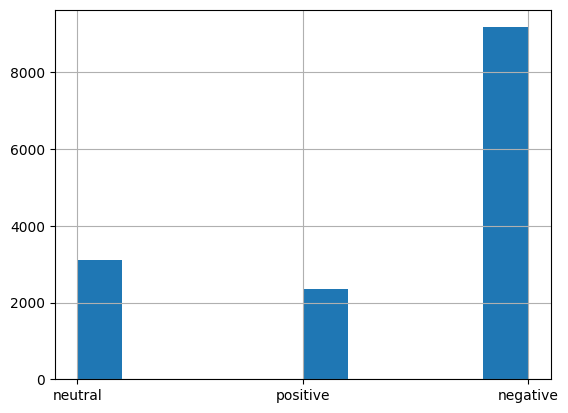

In [7]:
df['airline_sentiment'].hist()

In [8]:
df = df[df['airline_sentiment'] != 'neutral'].copy()

In [9]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)

In [10]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [11]:
df_train, df_test = train_test_split(df, random_state=42)

In [12]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

In [13]:
# data must not be sparse matrix before passing into tensorflow
X_train = X_train.toarray()
X_test = X_test.toarray()

In [14]:
Y_train = df_train['target']
Y_test = df_test['target']

In [15]:
# input dimensions
D = X_train.shape[1]

In [16]:
# build model
i = Input(shape=(D,))
x = Dense(1)(i) # sigmoid included in loss

model = Model(i, x)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1)                 2001      
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
model.compile(
  loss=BinaryCrossentropy(from_logits=True),
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy']
)

In [19]:
r = model.fit(
  X_train, Y_train,
  validation_data=(X_test, Y_test),
  epochs=40,
  batch_size=128,
)

Epoch 1/40
68/68 [==============================] - 5s 14ms/step - loss: 0.5014 - accuracy: 0.7920 - val_loss: 0.3967 - val_accuracy: 0.8049
Epoch 2/40
68/68 [==============================] - 1s 8ms/step - loss: 0.3748 - accuracy: 0.7976 - val_loss: 0.3390 - val_accuracy: 0.8226
Epoch 3/40
68/68 [==============================] - 1s 8ms/step - loss: 0.3215 - accuracy: 0.8192 - val_loss: 0.3026 - val_accuracy: 0.8413
Epoch 4/40
68/68 [==============================] - 1s 9ms/step - loss: 0.2844 - accuracy: 0.8455 - val_loss: 0.2769 - val_accuracy: 0.8597
Epoch 5/40
68/68 [==============================] - 1s 10ms/step - loss: 0.2571 - accuracy: 0.8644 - val_loss: 0.2583 - val_accuracy: 0.8773
Epoch 6/40
68/68 [==============================] - 1s 10ms/step - loss: 0.2364 - accuracy: 0.8810 - val_loss: 0.2446 - val_accuracy: 0.8888
Epoch 7/40
68/68 [==============================] - 1s 9ms/step - loss: 0.2199 - accuracy: 0.8930 - val_loss: 0.2339 - val_accuracy: 0.8992
Epoch 8/40
68/68 

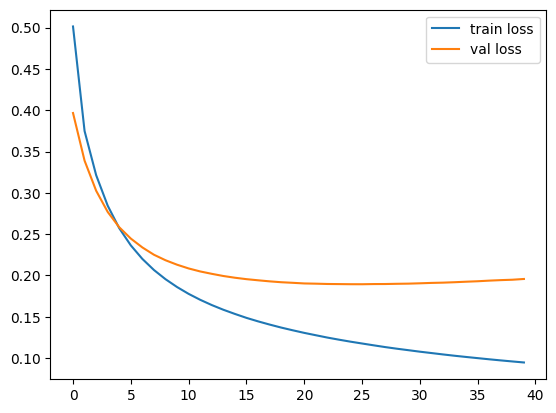

In [20]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

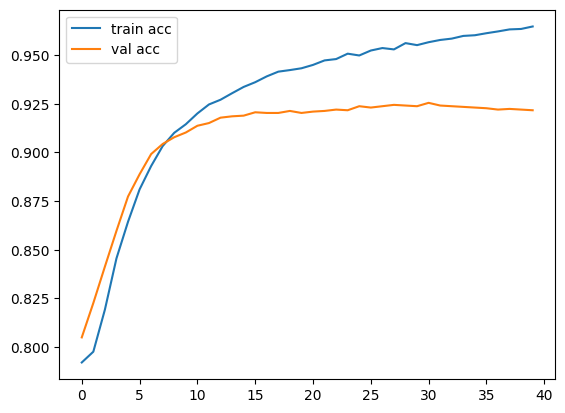

In [21]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();


In [25]:
P_train = ((model.predict(X_train) > 0) * 1.0).flatten()
P_test = ((model.predict(X_test) > 0) * 1.0).flatten()

91/91 [==============================] - 0s 1ms/step


In [26]:
cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

array([[0.99095551, 0.00904449],
       [0.1       , 0.9       ]])

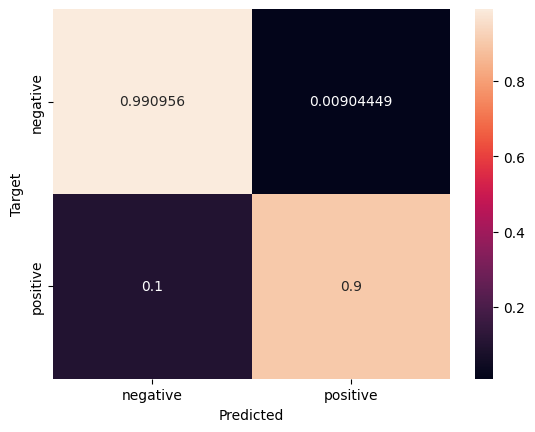

In [27]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

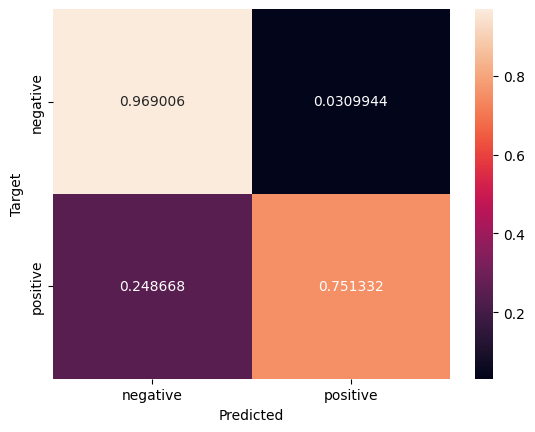

In [28]:
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
plot_cm(cm_test)

In [29]:
print("Train F1:", f1_score(Y_train, P_train))
print("Test F1:", f1_score(Y_test, P_test))

Train F1: 0.9304997128087307
Test F1: 0.7996219281663515


In [30]:
model.layers

In [31]:
model.layers[1].get_weights()

[array([[-3.7505958],
        [ 3.2542245],
        [-1.5538678],
        ...,
        [ 2.0392063],
        [ 1.6362331],
        [-2.9134104]], dtype=float32),
 array([-0.2543048], dtype=float32)]

In [32]:
w = model.layers[1].get_weights()[0]

In [33]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'jetblue': 975,
 'thanks': 1725,
 'for': 753,
 'having': 855,
 'us': 1857,
 'hang': 838,
 'out': 1265,
 'at': 195,
 'tampa': 1707,
 'airport': 120,
 'forever': 756,
 'today': 1765,
 'it': 966,
 'really': 1423,
 'been': 241,
 'an': 145,
 'awesome': 215,
 'experience': 655,
 'americanair': 141,
 'was': 1894,
 'told': 1768,
 'you': 1992,
 'could': 452,
 'only': 1248,
 'refund': 1439,
 'me': 1109,
 'the': 1729,
 'cost': 448,
 'of': 1227,
 'my': 1180,
 'original': 1257,
 'return': 1479,
 'flight': 725,
 'note': 1213,
 'had': 828,
 'booked': 270,
 'more': 1165,
 'expensive': 654,
 'everyone': 635,
 'else': 602,
 'outstanding': 1269,
 'united': 1840,
 'denver': 517,
 'to': 1764,
 'austin': 205,
 'still': 1660,
 'on': 1242,
 'ground': 820,
 'issue': 963,
 'is': 961,
 'lack': 1001,
 'announcement': 149,
 'made': 1088,
 'so': 1608,
 'late': 1012,
 'when': 1927,
 'gate': 793,
 'agent': 111,
 'there': 1733,
 'over': 1270,
 'hour': 897,
 'southwestair': 1628,
 'hold': 880,
 '30': 36,
 'min': 1142,

In [34]:
# let's look at the weights for each word
# try it with different threshold values!
threshold = 2

print("Most positive words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight > threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most positive words:
thank 9.80344
thanks 9.359368
worries 8.332844
great 7.918024
awesome 7.294099
love 7.2684517
excellent 7.085985
kudos 6.8327403
amazing 6.4486856
best 6.133733


In [35]:
print("Most negative words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight < -threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most negative words:
worst -9.383829
paid -7.8115005
not -7.752267
rude -7.5534744
disappointed -7.2310944
nothing -6.7925696
website -6.7900267
hung -6.6506667
instead -6.5720963
weren -6.1810594
